# ECOM90025 ADA: Tutorial 10 in Week 11

- Covering materials from week 10 lecture: marginal regression and PLS.

# My contact:
- Name: Zheng Fan
- Email: fan.z@unimelb.edu.au
- Send me an email if you have any general or conceptual questions
- I'm also happy to stay for a while after the tutorial.
- Consultataion: meet Dr Yong Song every Tuesday 1-2pm at FBE level-3 360.
- Special consideration: visit Stop 1.

# Tutorial participation 
- You need to actively participate instead of just showing up. 
- Attendance does not guarantee marks. 
- You may get a maximum of 10 points out of 11 tutorials.
- If you unable to come to school, seek help from Stop 1.

# Software:
- Google Colab is a free online platform where you can execute your code (especially for Python) and write text (LaTeX and Html) without any software installed.
- Local Jupyter Lab, which has been demonstrated during the lecture.
- Local Jupyter Notebook from Anaconda (My personal preference). Just download Anaconda, and then open Jupyter Notebook.
- Other IDE such as PyCharm, but I'm not very comfortable with using PyCharm. From what I know, the code saved in PyCharm is .py but not .ipynb, which may requires some conversion.

Although you can always use Colab, It is recommended to have a local machine installed.

#### You may access my tutorial code via: https://github.com/zhengf1/2023-S2-ADA or Canvas after Wednesday afternoon.
- <font color="red">
If you are using Google Colab, you can simply copy paste the code; or you can upload this ".ipynb" notebook file to Google Colab, which would look exactly the same as local Jupyter machine.
    </font>

# Housekeeping code to start with

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
import patsy
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.patches as mpatches
from sklearn.linear_model import LassoCV
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import mean_squared_error

# What shall I trust?

Industry-level software, such as STATA or Eviews, is mostly trustable because they are tested by both the producer and customers. In other words, they are heavily peer-reviewed.

For free software such as R or python, they have user-supplied packages. They usually have no warranty. But good packages have more downloads, are used by many professionals, and can be trusted. It is usually very cheap to test by yourself.

Algorithms in a paper or book (such as algorithm 21) can be misleading. Sometimes a simple typo or disclarity will destroy the user experience. Let's assume that functions from ` scikit` are correct and investigate algorithm 21.

# Let's first check the PLS package

## Gas Octane Data

- Y: octane rating.
- X: near-infrared (NIR) spectroscopy. 401 variables
- 60 observations

p >> n case

In [2]:
gas = pd.read_csv("https://www.dropbox.com/s/255h2nr3u82fj6j/gasoline.csv?dl=1")
octane = gas.iloc[:, 0]
nir= gas.iloc[:, 1:]

In [3]:
[octane.head(), nir.head()]

[0    85.30
 1    85.25
 2    88.45
 3    83.40
 4    87.90
 Name: octane, dtype: float64,
      900 nm    902 nm    904 nm    906 nm    908 nm    910 nm    912 nm  \
 0 -0.050193 -0.045903 -0.042187 -0.037177 -0.033348 -0.031207 -0.030036   
 1 -0.044227 -0.039602 -0.035673 -0.030911 -0.026675 -0.023871 -0.022571   
 2 -0.046867 -0.041260 -0.036979 -0.031458 -0.026520 -0.023346 -0.021392   
 3 -0.046705 -0.042240 -0.038561 -0.034513 -0.030206 -0.027680 -0.026042   
 4 -0.050859 -0.045145 -0.041025 -0.036357 -0.032747 -0.031498 -0.031415   
 
      914 nm    916 nm    918 nm  ...   1682 nm   1684 nm   1686 nm   1688 nm  \
 0 -0.031298 -0.034217 -0.036012  ...  1.198461  1.224243  1.242645  1.250789   
 1 -0.025410 -0.028960 -0.032740  ...  1.128877  1.148342  1.189116  1.223242   
 2 -0.024993 -0.029309 -0.033920  ...  1.147964  1.167798  1.198287  1.237383   
 3 -0.028280 -0.030920 -0.034012  ...  1.160089  1.169350  1.201066  1.233299   
 4 -0.034611 -0.037781 -0.040752  ...  1.25271

In [4]:
pls = PLSRegression(n_components=1)
pls.fit(nir, octane)
yhat1 = pls.predict(nir)

pls = PLSRegression(n_components=2)
pls.fit(nir, octane)
yhat2 = pls.predict(nir)

pls = PLSRegression(n_components=3)
pls.fit(nir, octane)
yhat3 = pls.predict(nir)

In [5]:
np.corrcoef(yhat1.ravel(), octane)

array([[1.        , 0.55265476],
       [0.55265476, 1.        ]])

In [6]:
np.corrcoef(yhat2.ravel(), octane)

array([[1.       , 0.8932727],
       [0.8932727, 1.       ]])

In [7]:
np.corrcoef(yhat3.ravel(), octane)

array([[1.        , 0.98859469],
       [0.98859469, 1.        ]])

These correlations are identical as the textbook.

Text(0.5, 1.0, 'Prediction v.s. True')

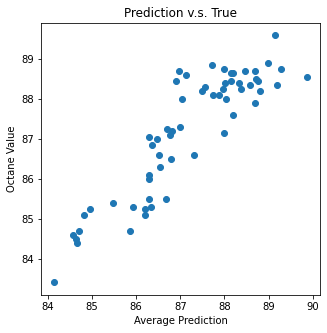

In [8]:
plt.figure(figsize=(5, 5))
scatter = plt.scatter(yhat2, octane, marker='o')
plt.xlabel('Average Prediction')
plt.ylabel('Octane Value')
plt.title('Prediction v.s. True')

# Let's check the PLS algorithm and see how it performs

# Partial Least Squares (PLS)


Algorithm 20 Marginal Regression (Page 226)

1. Calculate OLS coefficeint $\varphi_j=cor(x_j, y)/sd(x_j)$ for simple univariate regression of $y$ on $x_j$ for $j=1,...p$. (the formula in algorithm 20 seems wrong...)
1. Set $\nu_i=x_i'\varphi$ for each observation $i$
1. Fit the *forward* univaraite linear regression $y_i=\alpha + \beta v_i+ɛ_i$



---



PLS is repeated MR on its previously obtained residual.

Algorithm 21 Partial Lest Squares (Page 228)
1. start MR for $y$ on $x$. Denote the factor as $\nu^1$ and the fitted value $\hat{y}^1$.
1. For the $k$th iteration, get residuals (from the $k-1$th step) $\tilde{y}_i^{k-1}= y_i-\hat{y}_i^{k-1}$.
1. Repeat MR but use $\tilde{y}_i^{k-1}$ as the dependent variable.
1. Get new fitted value $\hat{y}^k_i=\hat{y}_i^{k-1}+\beta_k \nu_i^k$.

# Implement Algorithm 21

- Copy the tutorial sheet and download the Gas Octane data.
- Try PLS(3). 
- Compare the correlations to the result from the textbook or `SciKit`.

## MR 1

In [9]:
N, K = nir.shape
v = np.zeros(N)
for ii in range(K):
  x = nir.iloc[:, ii];
  phi = np.corrcoef(x, octane)[0,1] / np.std(x)
  v += x * phi

v /= K

In [10]:
model = smf.ols("octane~v", data=nir)
result = model.fit()

yhat1 = result.fittedvalues
residual1 = result.resid
np.corrcoef(octane, yhat1)[0,1]## MR 1

0.5526547567963024

## MR 2

In [11]:
y = residual1

N, K = nir.shape
v = np.zeros(N)
for ii in range(K):
  x = nir.iloc[:, ii];
  phi = np.corrcoef(x, y)[0,1] / np.std(x)
  v += x * phi

v /= K

In [12]:
model = smf.ols("y~v", data=nir)
result = model.fit()

yhat2 = yhat1 + result.fittedvalues
residual2 = result.resid
np.corrcoef(octane, yhat2)[0,1]

0.8932727009632153

## MR 3

In [13]:
y = residual2

N, K = nir.shape
v = np.zeros(N)
for ii in range(K):
  x = nir.iloc[:, ii];
  phi = np.corrcoef(x, y)[0,1] / np.std(x)
  v += x * phi

v /= K

In [14]:
model = smf.ols("y~v", data=nir)
result = model.fit()

yhat3 = yhat2 + result.fittedvalues
residual3 = result.resid
np.corrcoef(octane, yhat3)[0,1]

0.8120654969653444

The correlations between the true data and our predictions are different from the package (and the textbook).

# Do it Right

Can you read the source code for [`pls()`](https://rdrr.io/cran/textir/src/R/pls.R)? It does not look so simple, right? It is challenging because the theory is involved, and you are not required to go that far in this subject. But are you curious? There are a few points in the code missing in Algorithm 21.

1. The factors should be orthogonal. Think about PCA. Such orthogonality is achieved by regressing the latter factor on the previous ones to get the residuals.
1. The data requires first step normalisation.
1. The formula $\varphi_j=cor(x_j, y)/sd(x_j)$ is indeed used in the source code, but it is not the OLS coefficient.
1. It has scale and shift to facilitate computational stability.

Yong figured out that MR and PLS can be done via many linear regressions instead of using the formula from the textbook. It is intuitive and error-free. Now, let's try his algorithm.

## Step 1: MR

1. Estimate all possible univariate regressions.
1. Obtain their fitted values.
1. Average ALL fitted values as a factor!
1. Regress $y$ on this factor to get the first fit.

In [15]:
predicted_values = []

# For each x variable, run a simple regression and store the predicted values
for x_var in nir.columns:
    X = sm.add_constant(nir[x_var])
    model = sm.OLS(octane, X)
    result = model.fit()
    predicted_values.append(result.fittedvalues)

# Average the predicted values
v1 = np.mean(predicted_values, axis=0)

In [16]:
model = smf.ols("octane~v1", data=nir)
result = model.fit()
yhat1 = result.fittedvalues
residual1 = result.resid
np.corrcoef(octane, yhat1)[0,1]

0.5526547567963196

## step 2: PLS

1. Get the $y$ residuals from the previous regression. This will be your new $y$.
1. Use the same way as step 1 to get the second "factor".
1. Then, regress this "factor" on the first factor and obtain the residuals. This is the "factor" residual and the real second factor.
1. Regress the $y$ residual on the second factor to get the second fit.
1. The sum of the first and second fitted values is the new fitted value.

In [17]:
predicted_values = []
y = residual1

# For each x variable, run a simple regression and store the predicted values
for x_var in nir.columns:
    X = sm.add_constant(nir[x_var])
    model = sm.OLS(y, X)
    result = model.fit()
    predicted_values.append(result.fittedvalues)

# Average the predicted values
v2 = np.mean(predicted_values, axis=0)

In [18]:
model = smf.ols("v2~v1", data=nir)
result = model.fit()
v2 = result.resid

In [19]:
model = smf.ols("y~v2", data=nir)
result = model.fit()
yhat2 = yhat1 + result.fittedvalues
residual2 = result.resid
np.corrcoef(octane, yhat2)[0,1]

0.8932727009632352

## step 3: PLS one more time

- Similar to step 2, but orthogonalise the third "factor" by regressing it on the previous two factors to get the residual (the third real factor).

In [20]:
predicted_values = []
y = residual2

# For each x variable, run a simple regression and store the predicted values
for x_var in nir.columns:
    X = sm.add_constant(nir[x_var])
    model = sm.OLS(y, X)
    result = model.fit()
    predicted_values.append(result.fittedvalues)

# Average the predicted values
v3 = np.mean(predicted_values, axis=0)

In [21]:
model = smf.ols("v3~v1+v2", data=nir)
result = model.fit()
v3 = result.resid

In [22]:
model = smf.ols("y~v3", data=nir)
result = model.fit()
yhat3 = yhat2 + result.fittedvalues
residual3 = result.resid
np.corrcoef(octane, yhat3)[0,1]

0.9885946940561491

## This is end of our second last tutorial.

- Good luck with your presentation and empirical project!
- As Yong said, if you need more help, please reach him so that more consultations can be organized.